In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
from tqdm import tqdm

## 0. Histogram bin size

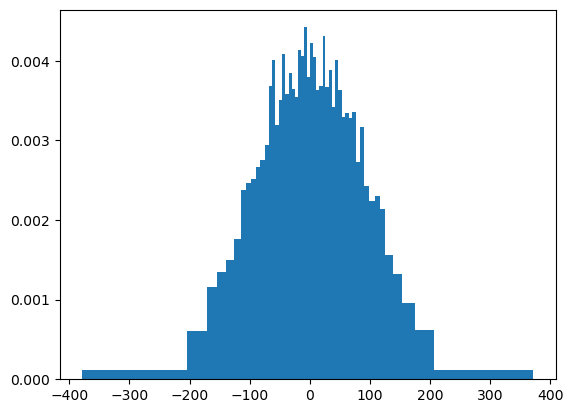

In [5]:
a = np.random.normal(0,100,10000)
plt.hist(a, bins=np.append(np.sort(a)[::200],max(a)), density=True)
plt.show()

# The irreducible mass of black holes

### 1. Generate mass and spin distributions

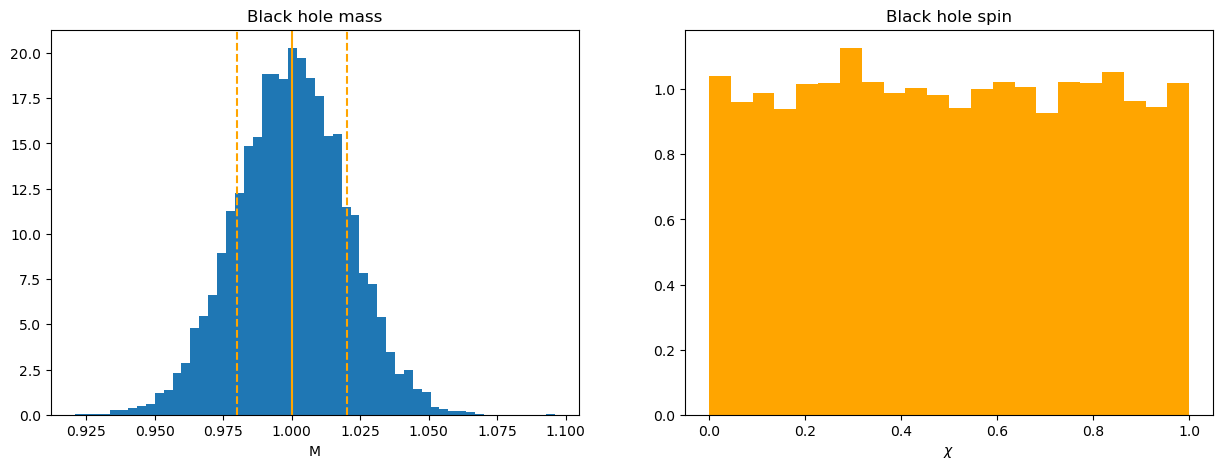

In [6]:
n_samples = 10000

mu = 1
sigma = 0.02
M = scipy.stats.norm(mu,sigma).rvs(n_samples)    # generate samples of M

X = scipy.stats.uniform(0,1).rvs(n_samples)      # and X

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.hist(M,bins='scott',density=True)
ax.axvline(mu,c='orange')
ax.axvline(mu+sigma,color='orange',linestyle='--')
ax.axvline(mu-sigma,color='orange',linestyle='--')
plt.xlabel('M')
plt.title('Black hole mass')

ax = fig.add_subplot(122)
ax.hist(X,bins='fd',color='orange',density=True)
plt.title('Black hole spin')
plt.xlabel('$\chi$')
plt.show()

### 2. Distribution of $M_{irr}$

### $M_{irr}=M\sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}$

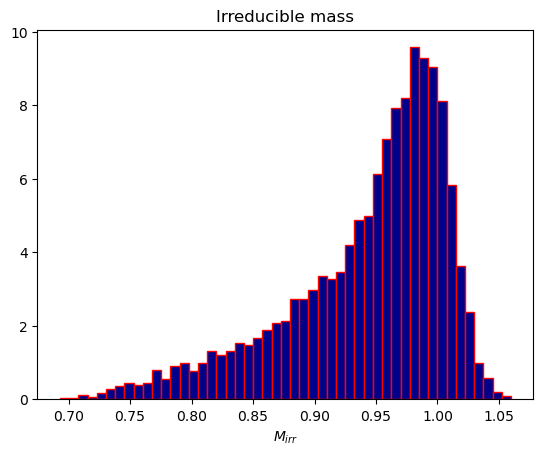

In [9]:
def f(x):                                         # M_irr / M
    return np.sqrt((1+np.sqrt(1-x**2))/2)

M_irr = M * f(X)      # compute irreducible mass from M and X

# draw histogram with Freeman-Diaconis rule
plt.hist(M_irr, bins="fd",color='darkblue',ec='r',density=True)
plt.title('Irreducible mass')
plt.xlabel('$M_{irr}$')
plt.show()

### 3. Kernel Density Estimation

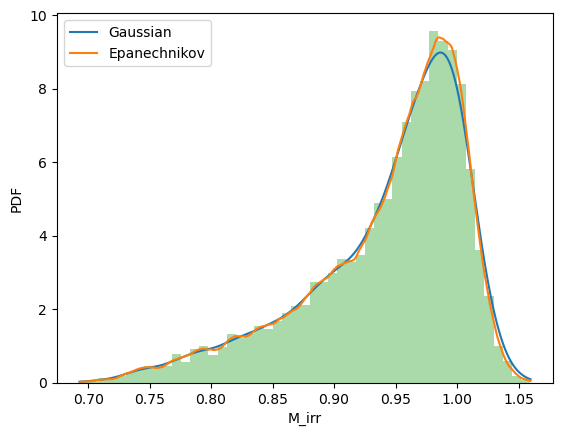

In [13]:
from sklearn.neighbors import KernelDensity
xgrid = np.linspace(min(M_irr),max(M_irr),1000)    # M_irr grid

def kde_sklearn(data, bandwidth, kernel):
    kde = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde.fit(data[:, np.newaxis])
    log_pdf = kde.score_samples(xgrid[:, np.newaxis]) 

    return np.exp(log_pdf)

bandwidth = 0.01
PDF_gaussian = kde_sklearn(M_irr,bandwidth,kernel="gaussian") 
PDF_epanechnikov = kde_sklearn(M_irr,bandwidth,kernel="epanechnikov") 

plt.plot(xgrid,PDF_gaussian,label='Gaussian') 
plt.plot(xgrid,PDF_epanechnikov,label='Epanechnikov') 
plt.hist(M_irr, bins="fd",density=True,alpha=0.4)
plt.legend()
plt.xlabel('M_irr')
plt.ylabel('PDF')
plt.show()

### 4. KS distance between M and f

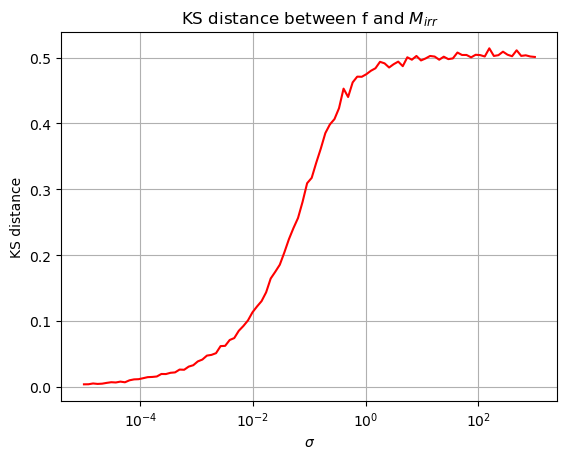

In [14]:
from scipy import stats, interpolate

Sigma = np.logspace(-5,3,100)

KSdist = []

for s in Sigma:
    
    m = stats.norm(mu,s).rvs(n_samples)         # sample masses from Gaussian pdf with the current sigma 
    M_i = m * f(X)                              # compute M_irr 
    function = M_i / m                          # compute f(X)

    KSdist.append(stats.ks_2samp(M_i, function)[:][0])
    
# plot KS vs sigma
plt.plot(Sigma,KSdist,c='r')
plt.xlabel('$\sigma$')
plt.ylabel('KS distance')
plt.title('KS distance between f and $M_{irr}$')
plt.grid()
plt.xscale('log')
plt.show()

For small values of $\sigma$ the KS distance tends to 0, i.e. $M_{irr}$ is distributed like $f$. For larger uncertainties KS increases and tends to 0.5 for $\sigma\gg\mu$.

### 5. KS distance between M and $M_{irr}$

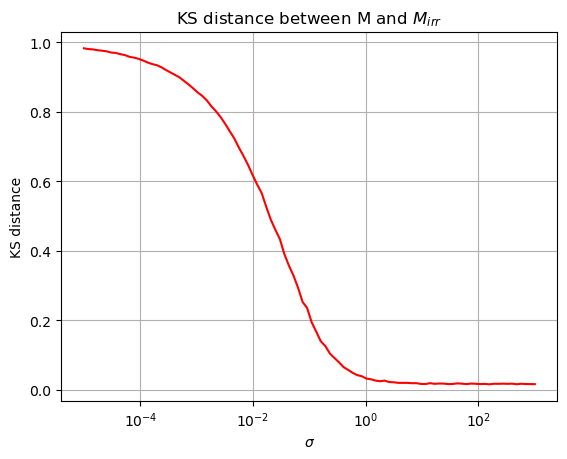

In [15]:
KSdist_ = []

for s in Sigma:
    
    m = stats.norm(mu,s).rvs(n_samples)
    M_i = m * f(X)

    KSdist_.append(stats.ks_2samp(M_i, m)[:][0])
    
# plot KS vs sigma
plt.plot(Sigma,KSdist_,c='r')
plt.xlabel('$\sigma$')
plt.ylabel('KS distance')
plt.title('KS distance between M and $M_{irr}$')
plt.grid()
plt.xscale('log')
plt.show()

For small values of $\sigma$ the KS distance tends to 1. For large uncertainties, KS tends to 0, meaning that the distributions of $M_{irr}$ and $M$ become close to each other. 

### 6. Limits of $M_{irr}$ distribution for large/small $\sigma$

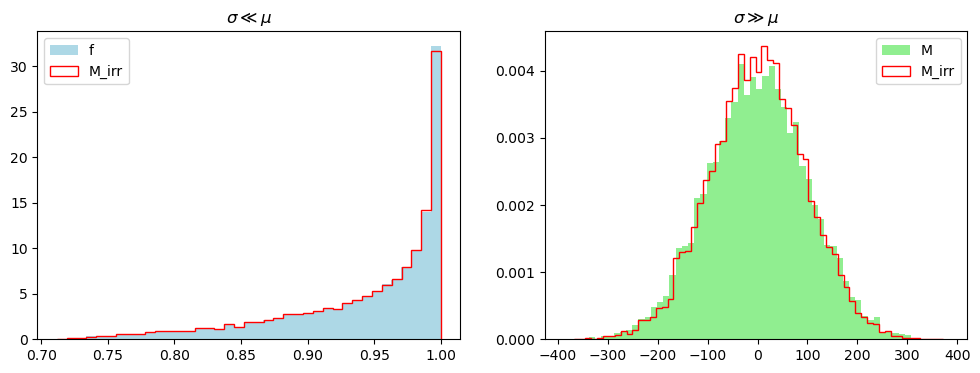

In [24]:
m = stats.norm(mu,0.0001).rvs(n_samples)       # small sigma <<mu
M_i = m * f(X)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.hist(f(X), bins='fd', color='lightblue', density=True, label='f')
ax.hist(M_i, bins='fd', histtype='step', color='r', density=True, label='M_irr')
plt.title('$\sigma\ll\mu$')
plt.legend()

m = stats.norm(mu,100).rvs(n_samples)        # large sigma >>mu
M_i = m * f(X)

ax = fig.add_subplot(122)
ax.hist(m, bins='fd', color='lightgreen', density=True, label='M')
ax.hist(M_i, bins='fd', histtype='step', color='r', density=True, label='M_irr')
plt.title('$\sigma\gg\mu$')
plt.legend()
plt.show()

### 7. Mathematical definition
$p(f)=\left|\frac{d\chi}{df}\right| p(\chi)$   

$p(\chi)=1$  

$f(\chi)=\sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}  =>  \chi(f)=\sqrt{1-(2f^2-1)^2}$

$\left|\frac{d\chi}{df}\right|=...=2\frac{2f^2-1}{\sqrt{1-f^2}} = p(f)$

$p(M)=\frac{1}{\sqrt{2\pi \sigma^2}} \exp\left[\frac{-(M-\mu)^2}{2\sigma^2}\right]$

$p(M_i)=\frac{\sqrt{2/\pi}}{\sigma}\int_{1/\sqrt{2}}^1{\exp\left[-\frac{(M_i/f-\mu)^2}{2\sigma^2}\right]\frac{2f^2-1}{f\sqrt{1-f^2}}df}$

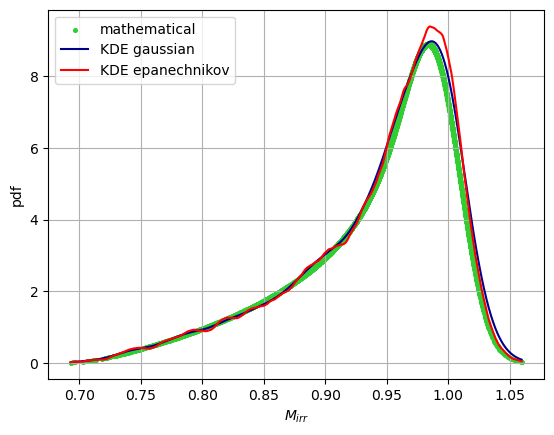

In [25]:
def intarg(f):
    return np.exp(-(M_irr/f-mu)**2/2/sigma**2) * (2*f**2-1)/(f*np.sqrt(1-f**2))

integral = 0
nbins = 500
df = (1-1/np.sqrt(2))/nbins
for i in range(nbins):
    integral += np.sqrt(2/np.pi)/sigma * intarg(1/np.sqrt(2)+i*df)*df

plt.scatter(M_irr,integral,s=7,c='limegreen',label='mathematical')
plt.plot(xgrid,PDF_gaussian,color='darkblue',label='KDE gaussian') 
plt.plot(xgrid,PDF_epanechnikov,color='r',label='KDE epanechnikov') 
plt.xlabel('$M_{irr}$')
plt.ylabel('pdf')
plt.legend()
plt.grid()
plt.show()

## Empirical CDF

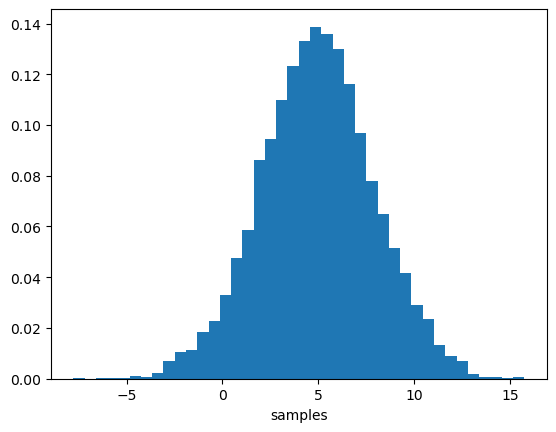

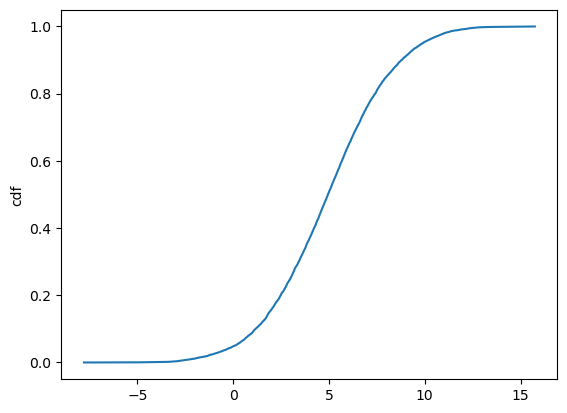

In [30]:
a = np.random.normal(5,3,10000)
plt.hist(a,40,density=True)
plt.xlabel('samples')
plt.show()

x = np.sort(a)
cdf = np.arange(len(x))  /len(x)
plt.plot(x,cdf)
plt.ylabel('cdf')
plt.show()